Stock Price Prediction

Importing Libraries


In [3]:
import pandas as pd
import pandas_ta as pta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError

Getting Data

In [4]:
stock_data = yf.download("BLK", start="2014-01-01", end="2024-01-01")
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BLK,BLK,BLK,BLK,BLK
Date,,,,,
2014-01-02,237.002594,238.957424,235.237208,238.957424,396500
2014-01-03,238.040680,239.419642,235.199376,236.358627,442900
2014-01-06,237.964783,240.677269,236.684300,239.639251,502400
2014-01-07,240.154480,242.177498,238.002669,238.002669,422700
2014-01-08,240.078720,241.957777,238.707320,240.700024,689100


In [5]:
train_stock_data = yf.download('BLK', start='2024-01-01', end='2024-12-31')
train_stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BLK,BLK,BLK,BLK,BLK
Date,,,,,
2024-01-02,781.635071,789.292249,776.878656,785.395315,660000
2024-01-03,765.861755,773.929062,764.084195,773.929062,638700
2024-01-04,767.619751,774.007201,764.474818,764.992486,580200
2024-01-05,764.572510,770.364201,763.234466,764.552957,471000
2024-01-08,778.597595,779.398478,764.650611,766.135180,513200


In [75]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, BLK)   2516 non-null   float64
 1   (High, BLK)    2516 non-null   float64
 2   (Low, BLK)     2516 non-null   float64
 3   (Open, BLK)    2516 non-null   float64
 4   (Volume, BLK)  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


In [76]:
train_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, BLK)   251 non-null    float64
 1   (High, BLK)    251 non-null    float64
 2   (Low, BLK)     251 non-null    float64
 3   (Open, BLK)    251 non-null    float64
 4   (Volume, BLK)  251 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


In [77]:
stock_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,BLK,BLK,BLK,BLK,BLK
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,453.488110,457.922589,448.921361,453.494743,6.666589e+05
std,182.044586,183.904779,180.193737,182.058904,4.427516e+05
min,216.992294,221.667168,215.772416,217.280188,1.264000e+05
25%,290.083534,292.285020,288.066422,290.073977,4.576750e+05
50%,403.038818,406.812212,399.649501,403.108573,5.808000e+05
75%,622.992020,630.083259,617.166087,624.111713,7.670750e+05
max,892.585083,894.119429,884.150694,892.612673,1.180410e+07


In [78]:
train_stock_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,BLK,BLK,BLK,BLK,BLK
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,856.214596,863.460085,849.065348,856.319349,5.944088e+05
std,100.839865,102.515154,99.786669,101.102687,2.373991e+05
min,734.400391,742.390055,732.680595,738.419813,2.508000e+05
25%,775.372314,780.975596,769.135408,775.405480,4.413000e+05
50%,815.269958,821.638091,808.076313,815.610714,5.398000e+05
75%,940.457947,947.318965,930.681333,940.502696,6.704000e+05
max,1065.260010,1082.449951,1060.280029,1068.189941,2.079800e+06


Data Observation

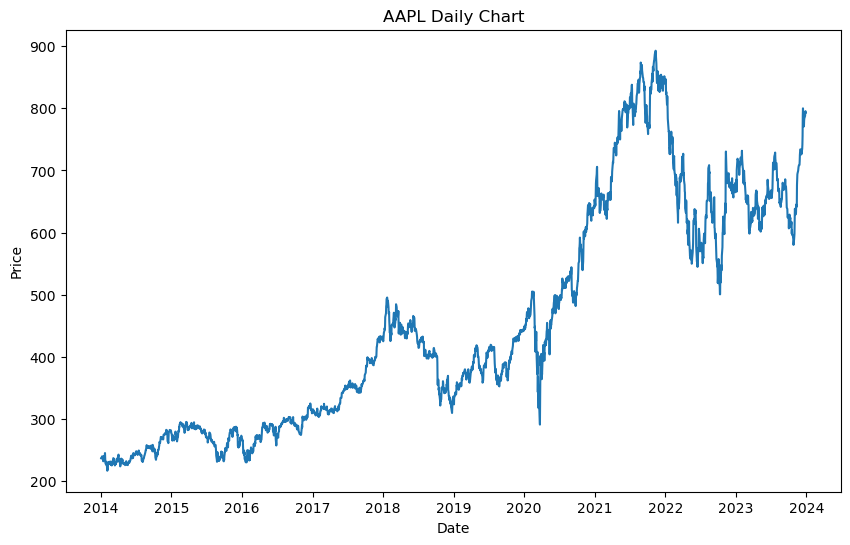

In [79]:
plt.figure(figsize = (10,6))
plt.plot(stock_data['Close'])
plt.title('AAPL Daily Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
def calculate_rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [7]:
def calculate_bollinger_bands(data, column='Close', period=20, std_dev=2):
    sma = data[column].rolling(window=period).mean()
    rolling_std = data[column].rolling(window=period).std()

    upper_band = sma + (rolling_std * std_dev)
    lower_band = sma - (rolling_std * std_dev)

    return upper_band, lower_band

In [8]:
def preprocess(stock_data):
    stock_data['D-1 Close'] = stock_data['Close'].shift(+1)
    stock_data['D-2 Close'] = stock_data['Close'].shift(+2)
    stock_data['D+1 Close'] = stock_data['Close'].shift(-1)

    stock_data['MA7'] = stock_data['Close'].rolling(7).mean()
    stock_data['MA14'] = stock_data['Close'].rolling(14).mean()
    stock_data['MA20'] = stock_data['Close'].rolling(20).mean()
    stock_data['MA50'] = stock_data['Close'].rolling(50).mean()
    stock_data['MA100'] = stock_data['Close'].rolling(100).mean()

    stock_data['EMA7'] = stock_data['Close'].ewm(span=7, adjust=False).mean()
    stock_data['EMA14'] = stock_data['Close'].ewm(span=14, adjust=False).mean()
    stock_data['EMA20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
    stock_data['EMA50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()
    stock_data['EMA100'] = stock_data['Close'].ewm(span=100, adjust=False).mean()

    stock_data['BB_Upper7'], stock_data['BB_Lower7'] = calculate_bollinger_bands(stock_data, period=7, std_dev=2)
    stock_data['BB_Upper14'], stock_data['BB_Lower14'] = calculate_bollinger_bands(stock_data, period=14, std_dev=2)
    stock_data['BB_Upper20'], stock_data['BB_Lower20'] = calculate_bollinger_bands(stock_data, period=20, std_dev=2)


    stock_data['RSI7'] = calculate_rsi(stock_data, 7)
    stock_data['RSI14'] = calculate_rsi(stock_data, 14)
    stock_data['RSI20'] = calculate_rsi(stock_data, 20)
    stock_data['RSI50'] = calculate_rsi(stock_data, 50)
    stock_data['RSI100'] = calculate_rsi(stock_data, 100)

    

In [9]:
preprocess(stock_data)

In [10]:
preprocess(train_stock_data)

In [11]:
stock_data = stock_data.dropna()
train_stock_data = train_stock_data.dropna()

In [12]:
stock_data.head(50)

Price,Close,High,Low,Open,Volume,D-1 Close,D-2 Close,D+1 Close,MA7,MA14,...,BB_Lower7,BB_Upper14,BB_Lower14,BB_Upper20,BB_Lower20,RSI7,RSI14,RSI20,RSI50,RSI100
Ticker,BLK,BLK,BLK,BLK,BLK,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-28,229.862122,233.171243,229.702009,232.378266,623000,232.271423,229.267410,232.416336,229.034276,229.247772,...,225.241347,233.159788,225.335756,232.582975,225.216756,52.643574,50.337224,49.647327,49.033078,48.814748
2014-05-29,232.416336,232.728952,230.228049,230.899003,406400,229.862122,232.271423,232.477310,229.668206,229.489576,...,225.264365,233.747125,225.232027,233.045815,225.045185,62.158821,55.278805,52.995255,50.394014,49.700722
2014-05-30,232.477310,233.308400,231.272617,232.004582,365100,232.416336,229.862122,233.339005,230.590783,229.628997,...,227.154794,234.152212,225.105782,233.474720,224.909820,62.369401,55.392912,53.073658,50.426259,49.721707
2014-06-02,233.339005,233.804124,230.517852,232.523155,404200,232.477310,232.416336,235.306091,231.258499,229.707970,...,227.753058,234.459886,224.956053,234.080564,224.839994,65.531860,57.060348,54.209844,50.886633,50.019368
2014-06-03,235.306091,236.625174,231.989362,232.454458,719300,233.339005,232.477310,236.937851,232.134242,230.015677,...,228.042835,235.610621,224.420733,235.059678,224.631731,71.835636,60.674256,56.727472,51.926572,50.692483
2014-06-04,236.937851,237.204720,233.643971,234.391201,558200,235.306091,233.339005,237.789368,233.230020,230.503116,...,228.643063,237.212847,223.793386,236.163962,224.628461,76.070969,63.424235,58.709800,52.773030,51.242689
2014-06-05,237.789368,238.495235,235.127059,237.497814,566400,236.937851,235.306091,240.881531,234.018297,231.311709,...,228.415957,238.628265,223.995152,237.408292,224.365185,78.077989,64.807252,59.723315,53.211710,51.527795
2014-06-06,240.881531,241.349557,238.295948,239.178265,457000,237.789368,236.937851,241.349365,235.592499,232.313387,...,229.291031,240.756468,223.870307,239.312408,223.646114,83.825438,69.340894,63.178203,54.768542,52.545629


In [13]:
train_stock_data.head(50)

Price,Close,High,Low,Open,Volume,D-1 Close,D-2 Close,D+1 Close,MA7,MA14,...,BB_Lower7,BB_Upper14,BB_Lower14,BB_Upper20,BB_Lower20,RSI7,RSI14,RSI20,RSI50,RSI100
Ticker,BLK,BLK,BLK,BLK,BLK,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-24,768.403137,775.763838,767.440013,773.788524,429000,771.007385,785.807495,758.094177,785.644610,782.691480,...,762.606867,806.829029,758.553932,811.720239,732.476288,36.959602,46.343636,47.583856,48.468540,48.766601
2024-05-28,758.094177,770.113108,752.266546,768.403153,636200,768.403137,771.007385,743.520203,780.548392,782.023921,...,751.026106,808.392317,755.655526,811.187392,734.004643,29.497831,41.601690,44.174122,46.886725,47.673313
2024-05-29,743.520203,752.708782,743.274518,750.114339,574900,758.094177,768.403137,748.709045,772.737026,780.497162,...,736.776476,812.918412,748.075912,810.968627,734.414057,22.129156,35.994441,39.917512,44.778569,46.194444
2024-05-30,748.709045,749.249540,740.817687,741.928187,650000,743.520203,758.094177,758.703552,766.653870,778.582925,...,730.934622,815.169988,741.995862,809.810348,736.582590,29.449610,39.139657,42.011651,45.666113,46.788081
2024-05-31,758.703552,760.924491,748.925293,749.888358,1616000,748.709045,743.520203,763.951355,762.034999,776.853306,...,733.362180,814.820926,738.885687,808.607977,739.262012,41.754160,44.769393,45.839112,47.329951,47.906319
2024-06-03,763.951355,766.241152,755.450644,766.034756,571000,758.703552,748.709045,771.734619,758.912694,775.943569,...,738.854526,814.533530,737.353608,807.882015,741.310740,47.376404,47.514708,47.745394,48.180162,48.480538
2024-06-04,771.734619,773.287363,761.248817,763.951348,666400,763.951355,758.703552,775.262695,759.016584,774.703212,...,738.660753,812.581343,736.825081,807.847477,742.391891,54.907828,51.375170,50.467186,49.415923,49.317488
2024-06-05,775.262695,775.459255,765.985642,775.134935,539800,771.734619,763.951355,765.091370,759.996521,772.820565,...,737.037912,807.413311,738.227820,808.038534,742.983103,58.080570,53.060560,51.668383,49.967795,49.691693


In [88]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2415 entries, 2014-05-28 to 2023-12-28
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, BLK)    2415 non-null   float64
 1   (High, BLK)     2415 non-null   float64
 2   (Low, BLK)      2415 non-null   float64
 3   (Open, BLK)     2415 non-null   float64
 4   (Volume, BLK)   2415 non-null   int64  
 5   (D-1 Close, )   2415 non-null   float64
 6   (D-2 Close, )   2415 non-null   float64
 7   (D+1 Close, )   2415 non-null   float64
 8   (MA7, )         2415 non-null   float64
 9   (MA14, )        2415 non-null   float64
 10  (MA20, )        2415 non-null   float64
 11  (MA50, )        2415 non-null   float64
 12  (MA100, )       2415 non-null   float64
 13  (EMA7, )        2415 non-null   float64
 14  (EMA14, )       2415 non-null   float64
 15  (EMA20, )       2415 non-null   float64
 16  (EMA50, )       2415 non-null   float64
 17  (EMA100, )     

In [15]:
def create_X_y(data):
    X = data.drop(['D+1 Close'],axis = 1)
    y = data['D+1 Close']
    return X,y

In [16]:
def split_data(stock_data):
    X, y = create_X_y(stock_data)

    X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2, random_state = 42)

    return X_train, y_train, X_cv, y_cv

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression 2": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "Polynomial Regression 4": make_pipeline(PolynomialFeatures(degree=4), LinearRegression()),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    
}

In [18]:
def evaluate_model(model, X_train, X_cv, X_test, y_train, y_cv, y_test):
    model.fit(X_train, y_train)
    
    y_cv_pred = model.predict(X_cv)
    y_test_pred = model.predict(X_test)

    
    mse_cv = mean_squared_error(y_cv, y_cv_pred)
    r2_cv = r2_score(y_cv, y_cv_pred)
    
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    return  mse_cv, r2_cv, mse_test, r2_test

In [19]:
def run_models(models, X_train, X_cv, X_test, y_train, y_cv, y_test):
    results = {}


    for name, model in models.items():
        mse_cv, r2_cv, mse_test, r2_test = evaluate_model(model, X_train, X_cv, X_test, y_train, y_cv, y_test)
        results[name] = {"MSE_cv": mse_cv, "R²_cv": r2_cv, "MSE_test": mse_test, "R²_test": r2_test}

    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by="R²_test", ascending=False)

    return results_df

In [22]:
X_train, y_train, X_cv, y_cv = split_data(stock_data)

X_test, y_test = create_X_y(train_stock_data)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

result = run_models(models, X_train_scaled, X_cv_scaled, X_test_scaled, y_train, y_cv, y_test)

result

,MSE_cv,R²_cv,MSE_test,R²_test
Linear Regression,73.679027,0.997779,109.629091,0.988950
Polynomial Regression 2,92.115844,0.997223,218.301479,0.977997
Decision Tree,134.923244,0.995933,6707.252447,0.323976
Random Forest,88.361394,0.997337,7963.120273,0.197398
XGBoost,116.693724,0.996483,10884.634861,-0.097062
Polynomial Regression 4,182248.675977,-4.493506,821610.788389,-81.810105


In [20]:
X_train, y_train, X_cv, y_cv = split_data(stock_data)

X_test, y_test = create_X_y(train_stock_data)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(units = 25, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
    Dense(units = 10, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
    Dense(units = 1, kernel_regularizer=tf.keras.regularizers.L2(0.05))
])

model.compile(
    loss = MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.005),
)

model.fit(X_train_scaled, y_train, epochs = 100)

Epoch 1/100


2025-01-05 22:00:49.543283: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-01-05 22:00:49.543318: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: ubuntu-Nitro-AN515-31
2025-01-05 22:00:49.543327: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: ubuntu-Nitro-AN515-31
2025-01-05 22:00:49.543531: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-01-05 22:00:49.543559: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-01-05 22:00:49.543566: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 231044.2500
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73245.4062
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37846.0938
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31968.9238
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24401.9844
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19004.4551
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15407.5020
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11754.0586
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9748.4727 
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6330.3506
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3835.7991
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2148.0781
Epoch 13/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1168.7397
Epoch 14/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 752.8583 
Epoch 15/100
61/61 ━━━━━━━━━━━━

In [24]:
y_train_pred = model.predict(X_train_scaled)
y_cv_pred = model.predict(X_cv_scaled)
y_test_pred = model.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_cv = mean_squared_error(y_cv, y_cv_pred)
r2_cv = r2_score(y_cv, y_cv_pred)
    
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)


results = {"MSE_train": mse_train, "R²_train": r2_train, "MSE_cv": mse_cv, "R²_cv": r2_cv, "MSE_test": mse_test, "R²_test": r2_test}

results

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


{'MSE_train': 78.99002808940948,
 'R²_train': 0.9975440713841074,
 'MSE_cv': 85.99007119373255,
 'R²_cv': 0.9974080085998349,
 'MSE_test': 133.57784874667723,
 'R²_test': 0.9865366960976066}